In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0627/weights_KD_segformer_0627_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0627(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0627(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.3
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 759ms/step - loss: 0.0683
Average validation loss: 0.6580154895782471
4/4 [==============================] - 7s 771ms/step - loss: 0.0683 - val_loss: 0.6580
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 10s 729ms/step - loss: 0.0487 - val_loss: 0.6580
Average validation loss: 0.6525808572769165
4/4 [==============================] - 10s 743ms/step - loss: 0.0487 - val_loss: 0.6553
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 13s 723ms/step - loss: 0.0361 - val_loss: 0.6553
Average validation loss: 0.5621596574783325
4/4 [==============================] - 13s 734ms/step - loss: 0.0361 - val_lo

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 697ms/step - loss: 4.1944e-05
Average validation loss: 0.013665925711393356
8/8 [==============================] - 6s 709ms/step - loss: 4.1944e-05 - val_loss: 0.0137
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 683ms/step - loss: 4.1172e-05 - val_loss: 0.0137
Average validation loss: 8.597744454164058e-06
8/8 [==============================] - 11s 695ms/step - loss: 4.1172e-05 - val_loss: 0.0068
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 17s 678ms/step - loss: 4.0914e-05 - val_loss: 0.0068
Average validation loss: 7.17055485210949e-07
8/8 [==============================] - 17s 690ms

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 689ms/step - loss: 7.2129e-05
Average validation loss: 0.015055720810778439
12/12 [==============================] - 8s 700ms/step - loss: 7.2129e-05 - val_loss: 0.0151
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 703ms/step - loss: 6.7355e-05 - val_loss: 0.0151
Average validation loss: 0.02920326714714368
12/12 [==============================] - 17s 713ms/step - loss: 6.7355e-05 - val_loss: 0.0221
Epoch 3/10
12/12 [==============================] - 26s 711ms/step - loss: 6.2675e-05 - val_loss: 0.0221
Average validation loss: 0.05347879724696961
12/12 [==============================] - 26s 721ms/step - loss: 6.2675e-05 - val_loss: 0.0326
Epoch 4/10
12/12 [==============================] - 34s 711ms/step - loss: 5.8645e-05 - val_loss: 0.0326
Average validation

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 703ms/step - loss: 4.7649e-05
Average validation loss: 0.021010778844356537
16/16 [==============================] - 11s 715ms/step - loss: 4.7649e-05 - val_loss: 0.0210
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 699ms/step - loss: 5.1239e-05 - val_loss: 0.0210
Average validation loss: 0.022387319011613727
16/16 [==============================] - 23s 711ms/step - loss: 5.1239e-05 - val_loss: 0.0217
Epoch 3/10
16/16 [==============================] - 34s 706ms/step - loss: 4.8670e-05 - val_loss: 0.0217
Average validation loss: 0.039413028200215194
16/16 [==============================] - 34s 718ms/step - loss: 4.8670e-05 - val_loss: 0.0276
Epoch 4/10
16/16 [==============================] - 46s 705ms/step - loss: 4.5918e-05 - val_loss: 0.0276
Average valida

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 715ms/step - loss: 4.3139e-05
Average validation loss: 0.03312572278082371
20/20 [==============================] - 15s 726ms/step - loss: 4.3139e-05 - val_loss: 0.0331
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 718ms/step - loss: 3.6665e-05 - val_loss: 0.0331
Average validation loss: 0.05100486295268638
20/20 [==============================] - 29s 730ms/step - loss: 3.6665e-05 - val_loss: 0.0421
Epoch 3/10
20/20 [==============================] - 43s 718ms/step - loss: 3.2584e-05 - val_loss: 0.0421
Average validation loss: 0.027868746616877615
20/20 [==============================] - 44s 728ms/step - loss: 3.2584e-05 - val_loss: 0.0373
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/wei

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 16s 664ms/step - loss: 4.8401e-05
Average validation loss: 0.03369364018241564
24/24 [==============================] - 16s 675ms/step - loss: 4.8401e-05 - val_loss: 0.0337
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 32s 662ms/step - loss: 4.8769e-05 - val_loss: 0.0337
Average validation loss: 0.0651848806689183
24/24 [==============================] - 32s 672ms/step - loss: 4.8769e-05 - val_loss: 0.0494
Epoch 3/10
24/24 [==============================] - 48s 664ms/step - loss: 4.2110e-05 - val_loss: 0.0494
Average validation loss: 0.020154281985014677
24/24 [==============================] - 48s 674ms/step - loss: 4.2110e-05 - val_loss: 0.0397
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weig

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 27s 669ms/step - loss: 8.6439e-05
Average validation loss: 0.0707213906571269
40/40 [==============================] - 27s 679ms/step - loss: 8.6439e-05 - val_loss: 0.0707
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 55s 683ms/step - loss: 7.6701e-05 - val_loss: 0.0707
Average validation loss: 0.030115713737905024
40/40 [==============================] - 55s 693ms/step - loss: 7.6701e-05 - val_loss: 0.0504
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 81s 662ms/step - loss: 6.8155e-05 - val_loss: 0.0504
Average validation loss: 0.028905669599771498
40/40 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 33s 682ms/step - loss: 4.8458e-05
Average validation loss: 0.042491405348603926
48/48 [==============================] - 33s 692ms/step - loss: 4.8458e-05 - val_loss: 0.0425
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 66s 686ms/step - loss: 3.9011e-05 - val_loss: 0.0425
Average validation loss: 0.03506487434303077
48/48 [==============================] - 67s 696ms/step - loss: 3.9011e-05 - val_loss: 0.0388
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 100s 685ms/step - loss: 3.3880e-05 - val_loss: 0.0388
Average validation loss: 0.02955883991671726
48/48 [==============================]

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 38s 683ms/step - loss: 6.7126e-05
Average validation loss: 0.03465124066652996
56/56 [==============================] - 39s 692ms/step - loss: 6.7126e-05 - val_loss: 0.0347
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 77s 683ms/step - loss: 4.8274e-05 - val_loss: 0.0347
Average validation loss: 0.031224068279178546
56/56 [==============================] - 78s 692ms/step - loss: 4.8274e-05 - val_loss: 0.0329
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 116s 684ms/step - loss: 3.8451e-05 - val_loss: 0.0329
Average validation loss: 0.020816204537238394
56/56 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 44s 680ms/step - loss: 4.6577e-05
Average validation loss: 0.18965172131447616
64/64 [==============================] - 44s 690ms/step - loss: 4.6577e-05 - val_loss: 0.1897
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 88s 680ms/step - loss: 2.9475e-05 - val_loss: 0.1897
Average validation loss: 0.16934792482237526
64/64 [==============================] - 88s 690ms/step - loss: 2.9475e-05 - val_loss: 0.1795
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 132s 681ms/step - loss: 2.2224e-05 - val_loss: 0.1795
Average validation loss: 0.07830344326998784
64/64 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 49s 681ms/step - loss: 3.7549e-05
Average validation loss: 0.021898333966318104
72/72 [==============================] - 50s 691ms/step - loss: 3.7549e-05 - val_loss: 0.0219
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 99s 682ms/step - loss: 2.5655e-05 - val_loss: 0.0219
Average validation loss: 0.030236600587765377
72/72 [==============================] - 100s 692ms/step - loss: 2.5655e-05 - val_loss: 0.0261
Epoch 3/10
72/72 [==============================] - 149s 680ms/step - loss: 2.0790e-05 - val_loss: 0.0261
Average validation loss: 0.028352689567125507
72/72 [==============================] - 149s 690ms/step - loss: 2.0790e-05 - val_loss: 0.0268
Epoch 4/10
72/72 [==============================] - 198s 681ms/step - loss: 1.7598e-05 - val_loss: 0.0268
Average va

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 55s 682ms/step - loss: 2.9333e-05
Average validation loss: 0.012816824717447162
80/80 [==============================] - 55s 692ms/step - loss: 2.9333e-05 - val_loss: 0.0128
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 110s 683ms/step - loss: 2.1195e-05 - val_loss: 0.0128
Average validation loss: 0.09375787936151028
80/80 [==============================] - 111s 693ms/step - loss: 2.1195e-05 - val_loss: 0.0533
Epoch 3/10
80/80 [==============================] - 166s 686ms/step - loss: 1.6059e-05 - val_loss: 0.0533
Average validation loss: 0.008885366399772466
80/80 [==============================] - 167s 696ms/step - loss: 1.6059e-05 - val_loss: 0.0385
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_06

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 65s 680ms/step - loss: 5.7315e-05
Average validation loss: 0.03424923217971809
96/96 [==============================] - 66s 689ms/step - loss: 5.7315e-05 - val_loss: 0.0342
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 131s 680ms/step - loss: 4.0422e-05 - val_loss: 0.0342
Average validation loss: 0.02381092928893243
96/96 [==============================] - 132s 689ms/step - loss: 4.0422e-05 - val_loss: 0.0290
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 198s 679ms/step - loss: 3.0944e-05 - val_loss: 0.0290
Average validation loss: 0.17251617518710796
96/96 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 81s 675ms/step - loss: 2.8298e-05
Average validation loss: 0.011446198355406523
120/120 [==============================] - 82s 685ms/step - loss: 2.8298e-05 - val_loss: 0.0114
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 164s 683ms/step - loss: 1.9648e-05 - val_loss: 0.0114
Average validation loss: 0.020686760482688745
120/120 [==============================] - 165s 693ms/step - loss: 1.9648e-05 - val_loss: 0.0161
Epoch 3/10
120/120 [==============================] - 247s 683ms/step - loss: 1.5742e-05 - val_loss: 0.0161
Average validation loss: 0.02404757815723618
120/120 [==============================] - 248s 692ms/step - loss: 1.5742e-05 - val_loss: 0.0187
Epoch 4/10
120/120 [==============================] - 331s 685ms/step - loss: 1.3834e-05 - val_loss: 0.

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 100s 693ms/step - loss: 2.4101e-05
Average validation loss: 0.018631488990245595
144/144 [==============================] - 101s 703ms/step - loss: 2.4101e-05 - val_loss: 0.0186
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 201s 693ms/step - loss: 1.7077e-05 - val_loss: 0.0186
Average validation loss: 0.011513791338074952
144/144 [==============================] - 203s 703ms/step - loss: 1.7077e-05 - val_loss: 0.0151
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 303s 696ms/step - loss: 1.3932e-05 - val_loss: 0.0151
Average validation loss: 0.3480605581430135
144/144 [=============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 112s 698ms/step - loss: 1.5678e-05
Average validation loss: 0.04136953392880969
160/160 [==============================] - 113s 708ms/step - loss: 1.5678e-05 - val_loss: 0.0414
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 226s 704ms/step - loss: 1.0821e-05 - val_loss: 0.0414
Average validation loss: 0.11005554991914294
160/160 [==============================] - 228s 714ms/step - loss: 1.0821e-05 - val_loss: 0.0757
Epoch 3/10
160/160 [==============================] - 341s 707ms/step - loss: 8.5409e-06 - val_loss: 0.0757
Average validation loss: 0.010305885231355205
160/160 [==============================] - 342s 717ms/step - loss: 8.5409e-06 - val_loss: 0.0539
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 142s 710ms/step - loss: 4.4771e-05
Average validation loss: 0.04352661777287722
200/200 [==============================] - 144s 720ms/step - loss: 4.4771e-05 - val_loss: 0.0435
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 285s 703ms/step - loss: 3.1312e-05 - val_loss: 0.0435
Average validation loss: 0.03881384705193341
200/200 [==============================] - 287s 713ms/step - loss: 3.1312e-05 - val_loss: 0.0412
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 428s 707ms/step - loss: 2.4424e-05 - val_loss: 0.0412
Average validation loss: 0.11790572270751
200/200 [=================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:23 - loss: 1.6239e-06

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 170s 709ms/step - loss: 2.2634e-05
Average validation loss: 0.03488777056336403
240/240 [==============================] - 173s 719ms/step - loss: 2.2634e-05 - val_loss: 0.0349
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 342s 705ms/step - loss: 1.5785e-05 - val_loss: 0.0349
Average validation loss: 0.023582070386085736
240/240 [==============================] - 344s 715ms/step - loss: 1.5785e-05 - val_loss: 0.0292
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_30\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 514s 705ms/step - loss: 1.2289e-05 - val_loss: 0.0292
Average validation loss: 0.01060463438819473
240/240 [=============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.12973016109262991, 0.0397835459868989, 0.0906738162403963, 0.04931336564288898, 0.03330964677051497, 0.03164293825267229, 0.029971422861701288, 0.028230873230445465, 0.047597384255579, 0.08945973829528811, 0.039453288181238326, 0.1774637192369645, 0.2528721433392584, 0.04334297230294646, 0.045774214369450617, 0.04306564942604874, 0.020059716620869583, 0.030082943557638773]
std_val_losses =  [0.2049978505957961, 0.03408720187494584, 0.09277231019512992, 0.04259518775873595, 0.019798254398320173, 0.019519218585665674, 0.016366029193131026, 0.028351573207119517, 0.05889213891940081, 0.11016365416684237, 0.05081785970621202, 0.23139661267094733, 0.3030440860750152, 0.05395970734565846, 0.06664181428563581, 0.07999342553313703, 0.020275479554633817, 0.042864602698097116]


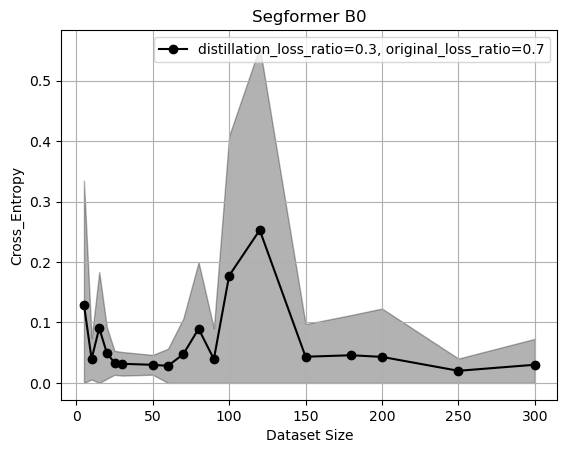

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0627')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0627_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0627_{int(teacher_ratio*100)}.png"))

plt.show()